# Walkthrough of Linear Algebra Functionality

With this section we will explore how to use various linear algebra operations with an emphasis on the dense and iterative base cases, rather than the dispatch rules. For high level operations like `solve`, `sqrt`, `logdet`, `eigs`, `exp`, `trace` the specific functions we call are listed in  [high-level API](https://cola.readthedocs.io/en/latest/package/cola.linalg.html), and low level iterative functions that help implement these operations such as `cg`, `gmres`, `lanczos`, `approx_diag`, `stochastic_lanczos_quadrature` are listed in [algorithms](https://cola.readthedocs.io/en/latest/package/cola.algorithms.html). These low level algorithms can also be called explicitly, but they will not be able to leverage our dispatch rules, and they sometimes require more involvement and knowledge from the user.

First let's set up some Linear operators to test these operations on. As we want to focus on the base cases, we will use a simple low rank + diagonal linear operator. We will use $A=UU^T+D$ as a prototype for a PSD matrix, $B=UV^T+D$ as a prototype for a generic square matrix, and $C=V^TD$ as a prototype for a generic rectangular matrix.

In [1]:
import torch
import numpy as np
import cola

N = 200
U = cola.lazify(torch.randn(N, 5))
V = cola.lazify(torch.randn(N, 5))
D = cola.ops.Diagonal(torch.linspace(1, 100, N))

A = U @ U.T + D  # a PSD matrix
B = U @ V.T + D  # a generic square matrix
C = V.T @ D  # a generic rectangular matrix

x = torch.ones(N)  # test vector x

Sometimes CoLA is able to infer additional properties of a Linear Operator such as `PSD`, `SelfAdjoint`, or `Unitary` but not always, so it's best to annotate these properties explicitly.

In order to let CoLA know that `A` is PSD, we will annotate it with the PSD annotation:

In [2]:
print("Properties before annotating:", A.annotations)
A = cola.PSD(A)
print("Properties after annotating:", A.annotations)

Properties before annotating: set()
Properties after annotating: {PSD}


Let's plot the spectrum of $A$ to get a sense for the kind of object that we are dealing with.

Text(0.5, 0, 'index')

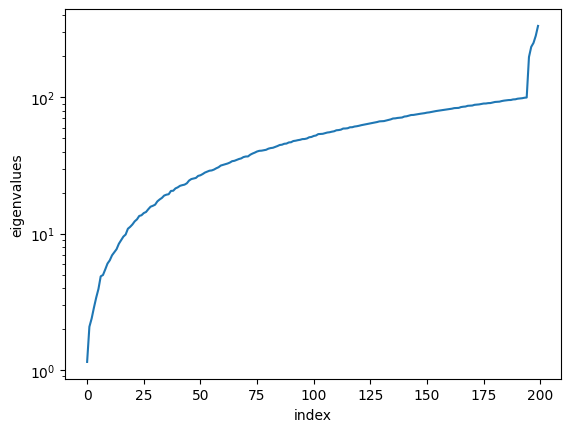

In [3]:
import matplotlib.pyplot as plt
plt.plot(torch.linalg.eigh(A.to_dense())[0])
plt.yscale('log')
plt.ylabel("eigenvalues")
plt.xlabel("index")

## Inverses / Linear Solves

For solving a linear system $Ax=b$, we may consider two cases where $A$ is a Positive-SemiDefinite symmetric matrix (PSD), and when it is not.

`cola.linalg.inv(A)` represents the linear operator $A^{-1}$ that, when applied to a vector $b$, it solves the linear system $A x = b$ and then outputs $x$.
It does not, however, compute the inverse densely $A^{-1}$ and then multiply it by the vector $b$, and is exactly equivalent to calling `cola.linalg.solve` as shown below.


### PSD

In [4]:
# these two are exactly equivalent in CoLA
y = cola.linalg.solve(A, x)
y = cola.linalg.inv(A) @ x

However with `cola.linalg.inv` we can examine the properties of the solve like the number of iterations it as taken to converge. Instead using the default `method=auto`, let's explicitly pick `method=dense` to use a dense $O(n^3)$ method or `method=iterative` to use an iterative $O(\tau \sqrt{\kappa}\log 1/\epsilon)$ where $\tau$ is the time for an MVM with $A$, $\kappa$ is the condition number of $A$ and $\epsilon$ is the desired error tolerance.

In [5]:
for alg in [cola.Cholesky(), cola.CG()]:
    Ainv = cola.linalg.inv(A, alg=alg)
    y = Ainv @ x
    print(f"With {alg}: Ainv of type {type(Ainv)}")
    if isinstance(alg, cola.CG):
        print(f"Computed inverse in {Ainv.info['iterations']} iters with error {Ainv.info['errors'][-1]:.1e}")

With <cola.linalg.decompositions.decompositions.Cholesky object at 0x7fa9cc28ec80>: Ainv of type <class 'cola.ops.operators.Product[cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular], cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular]]'>
With CG(tol=1e-06, max_iters=1000, pbar=False, x0=None, P=None): Ainv of type <class 'cola.linalg.algorithm_base.IterativeOperatorWInfo[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Dense], cola.ops.operators.Diagonal], cola.linalg.inverse.cg.CG]'>
Computed inverse in 69 iters with error 1.7e-06


In the dense case the `inverse` LinearOperator is computed via Cholesky decomposition
$A = LL^T$, and then using $A^{-1} = L^{-T}L^{-1}$ where $L^{-1}$ simply means a Linear Operator that performs triangular solves with $L$. We can see this reflected in the type of `Ainv`.

Meanwhile `iterative` uses Conjugate Gradients to perform multiplies with $A^{-1}$. With the iterative methods one often may want to specify an error tolerance or a maximum number of iterations to limit the computation.

In [6]:
Ainv = cola.linalg.inv(A, cola.CG(tol=1e-8, max_iters=1_000))
y = Ainv @ x
print(f"Computed inverse in {Ainv.info['iterations']} iters with error {Ainv.info['errors'][-1]:.1e}")

Computed inverse in 86 iters with error 1.5e-08


With this higher error tolerance, CG can converge in many fewer iterations, and in general one should choose error tolerances as high as are acceptable.

### Non PSD

Let's call the same functions but with the non PSD operator $B$.

In [7]:
for alg in [cola.LU(), cola.GMRES(tol=1e-3, max_iters=100)]:
    Binv = cola.linalg.inv(B, alg=alg)
    y = Binv @ x
    print(f"With {alg}: Ainv of type {type(Binv)}")
    if isinstance(alg, cola.GMRES):
        print(f"Computed inverse in {Binv.info['iterations']} iters with error {Binv.info['errors'][-1]:.1e}")

print(f"Actual residual error: {torch.linalg.norm(B @ y - x) / torch.linalg.norm(x):1.3e}")

With <cola.linalg.decompositions.decompositions.LU object at 0x7fa9cc28ca90>: Ainv of type <class 'cola.ops.operators.Product[cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular], cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular], cola.ops.operators.Permutation]'>
With GMRES(tol=0.001, max_iters=100, pbar=False, x0=None, P=None): Ainv of type <class 'cola.linalg.algorithm_base.IterativeOperatorWInfo[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Dense], cola.ops.operators.Diagonal], cola.linalg.inverse.gmres.GMRES]'>
Computed inverse in 101 iters with error 2.4e+01
Actual residual error: 1.014e-05


We can observe a few things here.
In the dense case, CoLA performs a PLU decomposition $B=P^{-1}LU$ and then computes the inverse as $U^{-1}L^{-1}P$ again using the implicit triangular solves, but this time combined with a permutation inverse.

In the iterative case, CoLA uses GMRES. Notably GMRES uses Arnoldi as a component of the algorithm, and the convergence criteria for Arnoldi depends on more than just residual errors that we care about for the linear solve. As a result of this more stringent convergence criteria, GMRES hits max_iters before stopping from the Arnoldi convergence tolerance, and the errors can be more easily controlled via changing max_iters.

In general CG has much more favorable properties over GMRES since with GMRES the memory requirement will grow with the number of iterations as will the compute, and hence if a matrix is PSD annotating it as such is highly preferable.

## Matrix Functions: $A^{1/2}$, $\exp(A)$, $\log(A)$, $f(A)$

Broadly we can consider many functions linear algebra operations $A^{1/2}$, $\exp(A)$, $\log(A)$
as instances of $f(A)$ where $f$ is assumed to have a convergent Taylor expansion within the bounds of the spectrum of $A$.

For 'method = dense', we compute these functions performing an eigendecomposition $A=P\Lambda P^{-1}$ and evaluate $f(A)=P f(\Lambda) P^{-1}$, and this runs in time $O(n^3)$.

For 'method = iterative', we evaluate matrix vector products $f(A)v$ using the Lanczos and Arnoldi processes starting with the vector $v$. Running in time $O(\tau \sqrt{\kappa}\log 1/\epsilon+m^3+mn)$ where $m$ is `max_iters`, this approach gives $\epsilon$ accurate evaluation of $f(A)v$. (With some extra effort the $m^3$ term can be reduced to $m^2$ but we have not yet implemented this optimization.)

For different $v$ the process will be run again, as Lanczos needs $v$ to construct a low error approximation.

### SelfAdjoint

Whether CoLA uses the more efficient Lanczos process or more costly version using Arnoldi depends on whether or not the matrix is `SelfAdjoint` (which gauruntees an orthogonal eigenbasis). `SelfAdjoint` is considered a superset of `PSD`.

In [8]:
print(A.annotations)
print(f"PSD: {A.isa(cola.PSD)}, SelfAdjoint: {A.isa(cola.SelfAdjoint)}")

{PSD}
PSD: True, SelfAdjoint: True


In [9]:
for alg in [cola.Auto(), cola.Lanczos(tol=1e-4, max_iters=100)]:
    S = cola.linalg.sqrt(A, alg=alg)
    print(f"S with method={alg} is of type {type(S)}")
    print("error in sqrt:", torch.linalg.norm(S @ (S @ x) - A @ x) / torch.linalg.norm(A @ x))

S with method=Auto() is of type <class 'cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Diagonal, cola.ops.operators.Dense]'>
error in sqrt: tensor(2.2412e-06)
S with method=Lanczos(start_vector=None, max_iters=100, tol=0.0001, pbar=False) is of type <class 'cola.linalg.unary.unary.LanczosUnary[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Dense], cola.ops.operators.Diagonal], function]'>
error in sqrt: tensor(1.2751e-06)


/home/ubu/venv/cola/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Callable deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


Likewise we can use `exp`, `log`, `pow`, and `apply_fn`

In [10]:
expA = cola.linalg.exp(-A)
logA = cola.linalg.log(A)
Apow10 = cola.linalg.pow(A, 10)
resolvent = cola.linalg.apply_unary(lambda x: 1 / (x - 1), A)
for op in [expA, logA, Apow10, resolvent]:
    print(op[:2, :2].to_dense())

tensor([[ 0.2980, -0.0502],
        [-0.0502,  0.1277]])
tensor([[0.2454, 0.1977],
        [0.1977, 0.8406]])
tensor([[1.3069e+22, 7.6425e+21],
        [7.6425e+21, 4.0476e+22]])
tensor([[ 6.2409, -1.4462],
        [-1.4462,  1.2435]])


### Non SelfAdjoint
For non self adjoint matrices the situation is the same, but it will use Arnoldi iterations. However, some of the operations like `log` and `sqrt` require that eigenvalues are $>0$ and may return Nan, Inf, or complex values depending on the inputs.

In [11]:
ops = [cola.linalg.sqrt(B), cola.linalg.exp(-B), cola.linalg.pow(B, 10)]
for op in ops:
    print(op[:2, :2].to_dense())

/home/ubu/cola/cola/backends/torch_fns.py:101: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  p_ids = (P @ torch.arange(P.shape[-1]).to(P.device, P.dtype)).to(torch.long)


tensor([[1.3539+0.1209j, 0.5808-0.3014j],
        [0.4983-0.2386j, 1.1996+0.5950j]])
tensor([[ 0.9728-1.5460e-07j, -2.1396+1.1176e-08j],
        [-1.7104+3.0128e-07j,  4.3459-5.8208e-10j]])
tensor([[-3.0144e+17+2.9045e+11j,  1.9648e+17+2.3139e+11j],
        [-5.0874e+17-9.9321e+09j,  4.3570e+17+4.4775e+11j]])


## Trace and Diagonal estimation

Unlike for Dense matrices, evaluating the trace or diagonal of a LinearOperators can be difficult (consider for example the diagonal of the Hessian of a neural network). Depending on the needs for the problem at hand we provide multiple different solutions:
- an exact $O(n\tau)$ compute and $O(\tau)$ memory evaluation which loops over the basis elements $A_{ii} = e_i^TAe_i$
- an stochastic Hutchinson estimator which is unbiased (always), but has runtime $O(1/\delta^2)$ where $\delta$ is the desired tolerance for the standard deviation of the estimate.

These can be chosen directly by specifying `method=exact`, `method=approx` or by letting the algorithm decide which will be faster based on the specified tolerance for the standard deviation `tol`. In general for methods which only need stochastic estimates (such as to be used in SGD) or only need one or two digits of precision, then the stochastic estimator will be faster.

We can use either of these two methods for
- computing the trace
- computing the diagonal
- computing off-diagonal diagonals

In [12]:
exact = cola.linalg.trace(A)
approx = cola.linalg.trace(A, alg=cola.Hutch(tol=3e-2))
print(f"exact trace: {exact}, stochastic trace: {approx}")

exact trace: 11140.4794921875, stochastic trace: 11141.3447265625


In [13]:
diag = cola.linalg.diag(A)
off_diag = cola.linalg.diag(A, k=1)
print(f"diagonal: {diag}")
print(f"off-diagonal: {off_diag}")

diagonal: tensor([  2.9105,   6.6579,   7.7880,   5.6944,   7.7207,   7.9493,  14.4669,
          8.6406,   8.4762,   9.9815,   9.2213,  11.6946,   9.1450,   9.1370,
         10.3431,  14.9943,  16.1334,  15.3012,  15.7201,  20.5606,  15.8162,
         20.9723,  23.4144,  17.0187,  16.9799,  18.2090,  19.6589,  19.2838,
         19.9156,  21.2470,  18.5541,  28.9271,  19.9661,  24.4216,  26.3321,
         21.9637,  23.7207,  27.7732,  26.0379,  24.5356,  30.4879,  25.0438,
         25.5871,  28.1174,  26.6907,  31.1649,  33.2315,  29.3582,  30.9795,
         27.6676,  29.1221,  41.0663,  32.8984,  31.9516,  34.2738,  30.2794,
         32.0154,  32.9081,  33.5838,  36.4766,  34.0875,  36.1036,  36.2640,
         47.3077,  36.1327,  36.5039,  39.2103,  42.3171,  38.7837,  38.6322,
         47.4495,  37.5737,  41.7417,  54.2067,  52.4848,  44.8467,  42.9181,
         43.8147,  50.5516,  41.1076,  44.5002,  45.7412,  44.9080,  45.0712,
         50.2902,  44.1144,  54.8404,  50.8947,  47.50

## Log Determinants

In the dense case, we compute log determinants from the Cholesky or LU decompositions depending on whether the matrix is PSD or not, and this runs in time $O(n^3)$.

For the iterative case we compute log determinants using the formula $\log\mathrm{det}(A) = \mathrm{Tr}(\log(A))$ combining together the $\log$ and $\mathrm{Tr}$ functions discussed above.

In the special case where only unbiased estimates (or a small number of significant digits) are required for the given use case, we can leverage [stochastic lanczos quadrature](https://www-users.cse.umn.edu/~saad/PDF/ys-2016-04.pdf) to get an improved convergence rate.

This choice is exposed to the user through the `method=iterative-stochastic` vs `method=iterative-exact` options in `logdet` and `slogdet`. If not chosen then they will be chosen automatically based on the selected `vtol` which chooses the "variance" tolerance specifying the standard deviation of the estimate.

For stochastic estimation, a key (`long` for pytorch, `PRNGKey` for jax) should be provided to explicitly to seed the randomness.

In [14]:
print("Tr(log(A))", cola.linalg.logdet(A, trace_alg=cola.Hutch(tol=1e-4), log_alg=cola.Lanczos(tol=1e-4, max_iters=30)))
print("SLQ:", cola.linalg.logdet(A, log_alg=cola.Lanczos(tol=1e-3, max_iters=10), trace_alg=cola.Auto()))
print("Dense:", cola.linalg.logdet(A))

Tr(log(A)) tensor(740.6740)
SLQ: tensor(740.7073)
Dense: tensor(740.6740)


And we can do this for non PSD matrices too using $\log \mathrm{det}(A) = \frac{1}{2}\log \mathrm{det}(A^TA)$, however the phase (sign) is lost in this process.

In [15]:
print("iterative:", cola.linalg.slogdet(B, log_alg=cola.Arnoldi(tol=1e-3, max_iters=10)))
print("Dense:", cola.linalg.slogdet(B, log_alg=cola.LU()))

iterative: (tensor(1.0000+0.0025j), tensor(731.9401))
Dense: (tensor(-1.), tensor(732.7272))


## Eigendecomposition

Another popular linear algebra operation is to find an approximation for the eigenvalues or eigenvectors of given linear operator $A$. That is, find $V$ and $\Lambda$ such that $AV = V \Lambda$.

In [16]:
eig_vals, eig_vecs = cola.eig(A, k=A.shape[0])

Nevertheless, when $A$ is quite large we cannot afford the time or memory for a full decomposition. We could thus use an iterative eigenvalue algorithm such as power iteration (if we only want the maximum eigenvalue), Lanczos (if we have a symmetric operator) or Arnoldi (which works in general). Let's see how to run all of those options.
So to compute the maximum eigenvalue we could run

In [17]:
from cola.linalg.eig.power_iteration import power_iteration
_, eig_max, _ = power_iteration(A, tol=1e-4)
print(f"eigmax: {eig_max}")
print(f"eig_vals[0]: {eig_vals[-1]}")

eigmax: 333.77655029296875
eig_vals[0]: 333.83392333984375


Indeed we recover the largest eigenvalue. The algorithm that `CoLA` ran in this case was the power method which runs in time $O(\tau\frac{1}{\Delta} \log 1/\epsilon)$ to compute the top eigenvalue. But we can achieve an accelerated convergence rate $O(\tau\frac{1}{\sqrt{\Delta}} \log 1/\epsilon)$ if we use Lanczos and Arnoldi, however this comes at an additional memory cost of $O(nm+m^2)$ where $m$ is `max_iters`.

In [18]:
e0, v0 = cola.eig(A, k=A.shape[0], which="SM", alg=cola.Lanczos(tol=1e-4, max_iters=15))
print(f"{e0[-1]}")

333.8339538574219


## 🚧 SVD (under development) 🚧

## 🚧 Pseudoinverse (under development) 🚧